In [16]:
import numpy as np
import scipy.signal as sp
import matplotlib.pyplot as plt

#### Функции

In [17]:
# Диаграмма нулей и полюсов
def ZerosPolesDiagram(z, p):
    fg, ax = plt.subplots(figsize=(5, 5))
    circle = plt.Circle(xy=(0,0),radius=1, edgecolor='gray', facecolor='white', linestyle='--')
    ax.add_patch(circle)
    ax.scatter(z.real, z.imag, marker='o', facecolor='white', edgecolor='C0', s=100)
    ax.scatter(p.real, p.imag, marker='x', s=100)
    ax.axhline(y=0, color="black", linestyle="-")
    ax.axvline(x=0, color="black", linestyle="-")
    ax.grid()
    plt.show()

# Расчет АЧХ
def FrequencyResponse(h):
    with np.errstate(divide='ignore'): # suppress RuntimeWarning: divide by zero encountered in log10
        return 20 * np.log10(abs(h))

# Расчет ФЧХ
def PhaseResponse(h):
    return np.unwrap(np.angle(h))

# Графики АЧХ и ФЧХ
def FRPRDiagram(w, fr, pr, logx = False, **kwargs):
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(8,5), layout='constrained')

    if (logx):
        ax[0].semilogx(w, fr, 'b')
    else:
        ax[0].plot(w, fr, 'b')
    ax[0].set_ylabel('Амплитуда, дБ', color='b')
    ax[0].set_xlabel('Частота, рад/с')
    ax[0].grid(True)

    if (logx):
        ax[1].semilogx(w, pr, 'g')
    else:
        ax[1].plot(w, pr, 'g')
    ax[1].set_ylabel('Фаза, рад', color='g')
    ax[1].set_xlabel('Частота, рад/с')
    ax[1].grid(True)

    if 'title' in kwargs.keys():
        fig.suptitle(kwargs['title'])

    if 'ylimits' in kwargs.keys():
        ax[0].set_ylim(kwargs['ylimits'])

    if 'xvlines' in kwargs.keys():
        for xvline in kwargs['xvlines']:
            for axis in ax:
                axis.axvline(x=xvline, color='gray', linestyle='dashed', linewidth=1.5)
    
    plt.show()

# Оболочка для отрисовки графика при вызове функций freqs и freqz в линейном масштабе
def FRPRDiag (w, h):
    FRPRDiagram(w, FrequencyResponse(h), PhaseResponse(h), logx=False)

# Оболочка для отрисовки графика при вызове функций freqs и freqz в логарифмическом масштабе
def FRPRDiagLog (w, h):
    FRPRDiagram(w, FrequencyResponse(h), PhaseResponse(h), logx=True)


#### Синтез прототипа аналогового фильтра нижних частот Бесселя

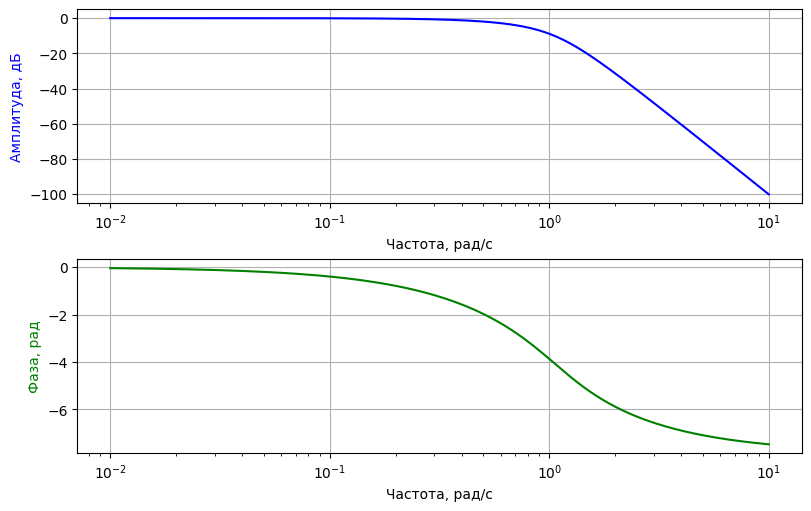

In [18]:
# Синтез прототипа аналогового фильтра нижних частот Бесселя
# Возвращаемые значения:
# z - значения нулей фильтра
# p - значения полюсов фильтра
# k - коэффициент усиления фильтра
# Параметры:
# N - порядок фильтра
# norm - частотная нормализация:
#   'phase' (по умолчанию) - фильтр нормализуется таким образом, чтобы среднее значение ФЧХ приходилось на частоту 1 рад/с;
#   'delay' - фильтр нормализуется таким образом, чтобы групповая задержка в полосе пропускания равнялась 1
#   'mag' - фильтр нормализуется таким образом, чтобы для частоты 1 рад/c значение АЧХ равнялось -3 дБ.
z, p, k = sp.besselap(N=5, norm='phase')

# Функция freqs_zpk возвращает отклик аналогового фильтра
# Возвращаемые значения:
# w - частоты, для которых был рассчитан отклик фильтра
# h - отклик фильтра, представленный в виде комплексных чисел
# Параметры:
# z - значения нулей фильтра
# p - значения полюсов фильтра
# k - коэффициент усиления фильтра
w, h = sp.freqs_zpk(z=z, p=p, k=k)
FRPRDiagLog(w, h)

#### Синтез фильтра нижних частот по характеристикам прототипа

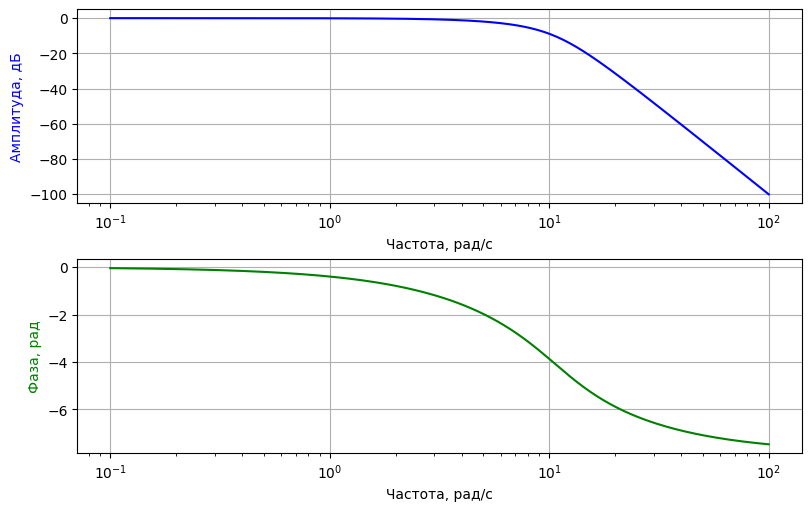

In [19]:
# Синтез фильтра нижних частот по характеристикам прототипа
# Возвращаемые значения:
# z - значения нулей фильтра
# p - значения полюсов фильтра
# k - коэффициент усиления фильтра
# Параметры:
# z - значения нулей фильтра
# p - значения полюсов фильтра
# k - коэффициент усиления фильтра
# wo - новая частота среза
z1, p1, k1 = sp.lp2lp_zpk(z=z, p=p, k=k, wo=10)
w1, h1 = sp.freqs_zpk(z=z1, p=p1, k=k1)
FRPRDiagLog (w1, h1)

#### Преобразование прототипа фильтра нижних частот из формы zpk в форму ba и синтез фильтра нижних частот по характеристикам прототипа

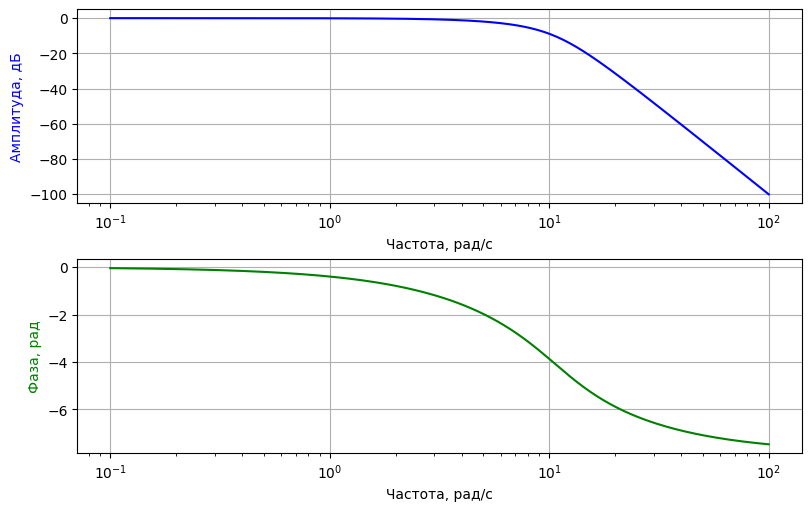

In [20]:
# Преобразование прототипа фильтра нижних частот, представленного в виде значений нулей, полюсов и коэффициента усиления
# в форму коэффициентов прямых и обратных связей
# Возвращаемые значения:
# b - коэффициенты прямых связей
# a - коэффициенты обратных связей
# Параметры:
# z - значения нулей фильтра
# p - значения полюсов фильтра
# k - коэффициент усиления фильтра
b, a = sp.zpk2tf(z=z, p=p, k=k)

# Синтез фильтра нижних частот по характеристикам прототипа
# Возвращаемые значения:
# b - коэффициенты прямых связей
# a - коэффициенты обратных связей
# Параметры:
# b - коэффициенты прямых связей
# a - коэффициенты обратных связей
# wo - новая частота среза
b1, a1 = sp.lp2lp(b=b, a=a, wo=10)

# Функция freqs позволяет указать в качестве параметра plot функцию для отрисовки графиков,
# принимающую в качестве параметров частоты, для которых был измерен отклик фильтра, и комплексные значения этих откликов.
w2, h2 = sp.freqs(b=b1, a=a1, plot=FRPRDiagLog)

#### Синтез фильтра верхних частот по характеристикам прототипа

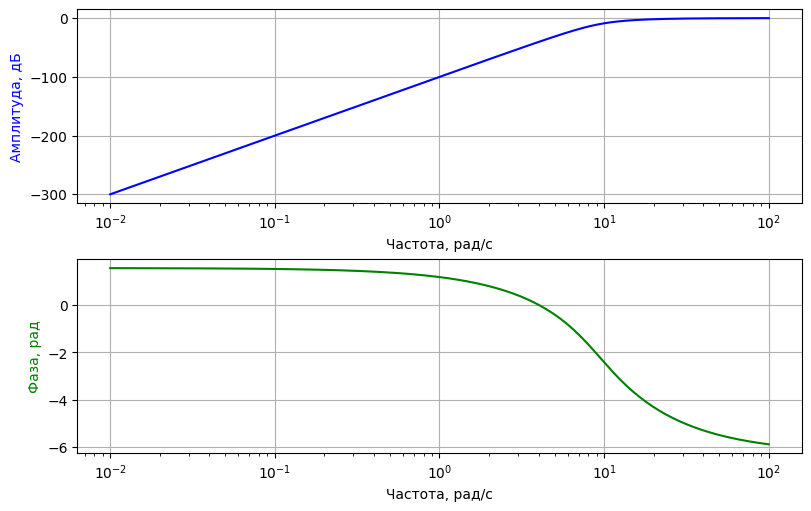

In [21]:
# Синтез фильтра верхних частот по характеристикам прототипа
# Возвращаемые значения:
# z - значения нулей фильтра
# p - значения полюсов фильтра
# k - коэффициент усиления фильтра
# Параметры:
# z - значения нулей фильтра
# p - значения полюсов фильтра
# k - коэффициент усиления фильтра
# wo - новая частота среза
z1, p1, k1 = sp.lp2hp_zpk(z=z, p=p, k=k, wo=10)
w1, h1 = sp.freqs_zpk(z=z1, p=p1, k=k1)
FRPRDiagLog (w1, h1)

#### Преобразование прототипа фильтра нижних частот из формы zpk в форму ba и синтез фильтра верхних частот по характеристикам прототипа

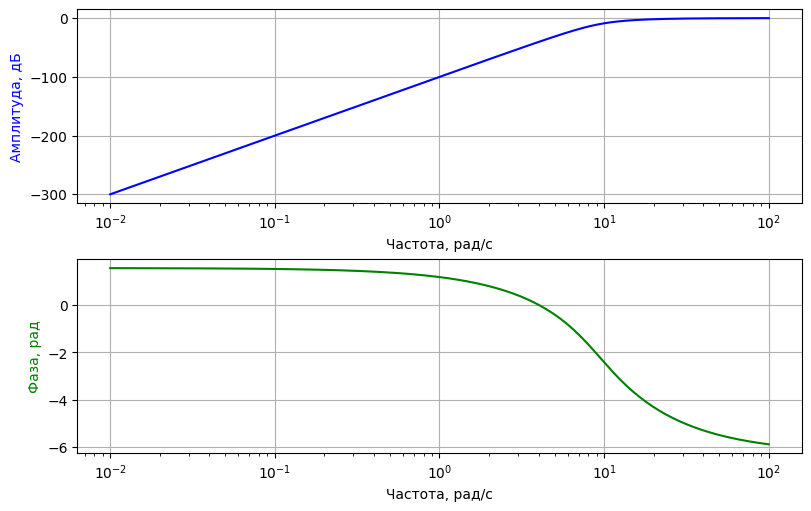

In [22]:
# Преобразование прототипа фильтра нижних частот, представленного в виде значений нулей, полюсов и коэффициента усиления
# в форму коэффициентов прямых и обратных связей
# Возвращаемые значения:
# b - коэффициенты прямых связей
# a - коэффициенты обратных связей
# Параметры:
# z - значения нулей фильтра
# p - значения полюсов фильтра
# k - коэффициент усиления фильтра
b, a = sp.zpk2tf(z=z, p=p, k=k)

# Синтез фильтра верхних частот по характеристикам прототипа
# Возвращаемые значения:
# b - коэффициенты прямых связей
# a - коэффициенты обратных связей
# Параметры:
# b - коэффициенты прямых связей
# a - коэффициенты обратных связей
# wo - новая частота среза
b1, a1 = sp.lp2hp(b=b, a=a, wo=10)

# Функция freqs позволяет указать в качестве параметра plot функцию для отрисовки графиков,
# принимающую в качестве параметров частоты, для которых был измерен отклик фильтра, и комплексные значения этих откликов.
w2, h2 = sp.freqs(b=b1, a=a1, plot=FRPRDiagLog)

#### Синтез полосового фильтра по характеристикам прототипа

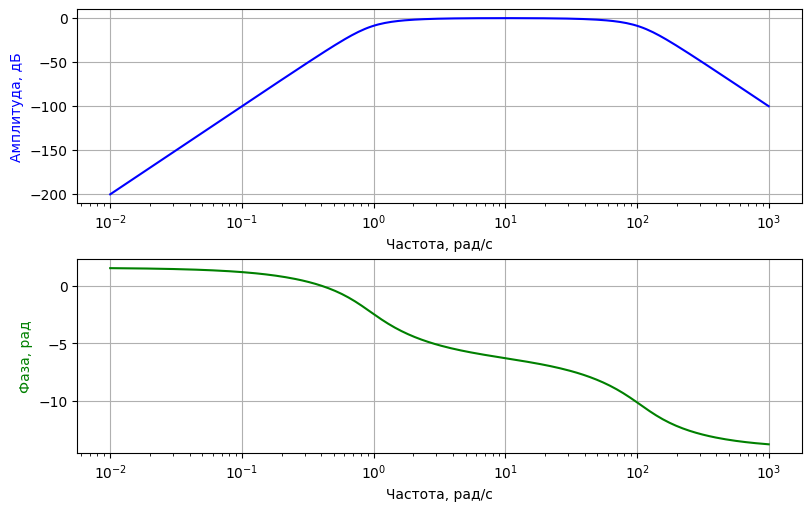

In [23]:
# Синтез полосового фильтра по характеристикам прототипа
# Возвращаемые значения:
# z - значения нулей фильтра
# p - значения полюсов фильтра
# k - коэффициент усиления фильтра
# Параметры:
# z - значения нулей фильтра
# p - значения полюсов фильтра
# k - коэффициент усиления фильтра
# wo - частота середины полосы пропускания
# bw - ширина полосы пропускания
z1, p1, k1 = sp.lp2bp_zpk(z=z, p=p, k=k, wo=10, bw=100)
w1, h1 = sp.freqs_zpk(z=z1, p=p1, k=k1)
FRPRDiagLog (w1, h1)

#### Преобразование прототипа фильтра нижних частот из формы zpk в форму ba и синтез полосового фильтра по характеристикам прототипа

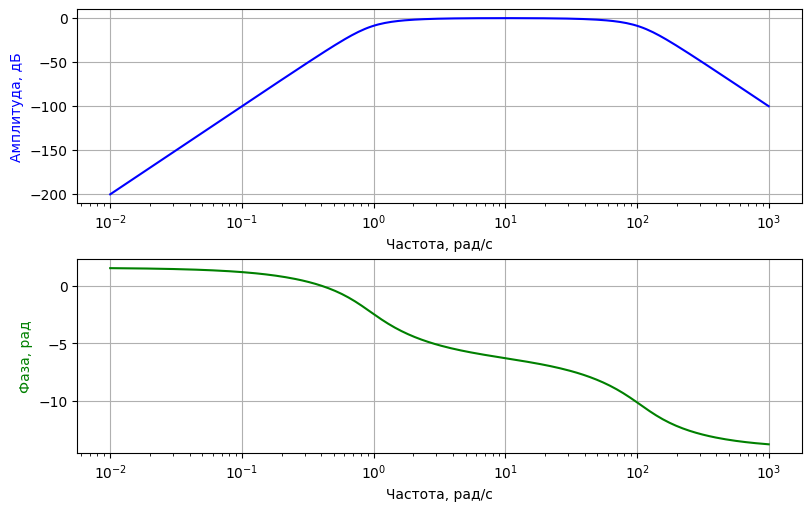

In [24]:
# Преобразование прототипа фильтра нижних частот, представленного в виде значений нулей, полюсов и коэффициента усиления
# в форму коэффициентов прямых и обратных связей
# Возвращаемые значения:
# b - коэффициенты прямых связей
# a - коэффициенты обратных связей
# Параметры:
# z - значения нулей фильтра
# p - значения полюсов фильтра
# k - коэффициент усиления фильтра
b, a = sp.zpk2tf(z=z, p=p, k=k)

# Синтез полосового фильтра по характеристикам прототипа
# Возвращаемые значения:
# b - коэффициенты прямых связей
# a - коэффициенты обратных связей
# Параметры:
# b - коэффициенты прямых связей
# a - коэффициенты обратных связей
# wo - частота середины полосы пропускания
# bw - ширина полосы пропускания
b1, a1 = sp.lp2bp(b=b, a=a, wo=10, bw=100)

# Функция freqs позволяет указать в качестве параметра plot функцию для отрисовки графиков,
# принимающую в качестве параметров частоты, для которых был измерен отклик фильтра, и комплексные значения этих откликов.
w2, h2 = sp.freqs(b=b1, a=a1, plot=FRPRDiagLog)

#### Синтез режекторного фильтра по характеристикам прототипа

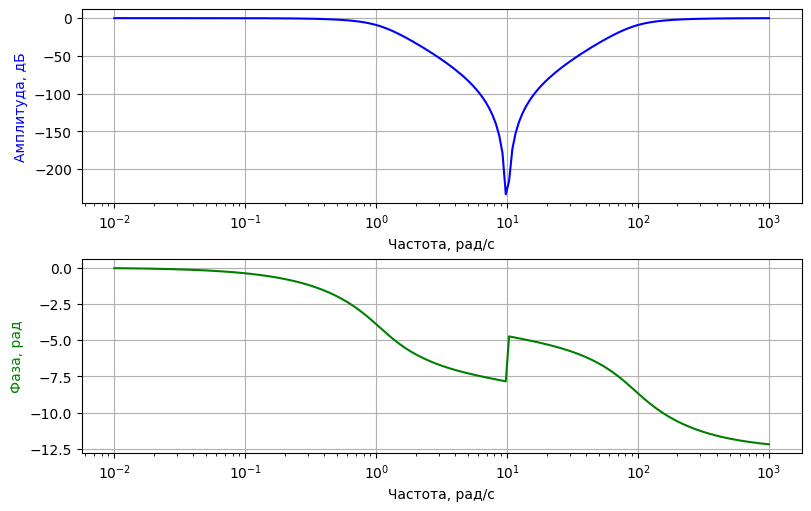

In [25]:
# Синтез режекторного фильтра по характеристикам прототипа
# Возвращаемые значения:
# z - значения нулей фильтра
# p - значения полюсов фильтра
# k - коэффициент усиления фильтра
# Параметры:
# z - значения нулей фильтра
# p - значения полюсов фильтра
# k - коэффициент усиления фильтра
# wo - частота середины полосы подавления
# bw - ширина полосы подавления
z1, p1, k1 = sp.lp2bs_zpk(z=z, p=p, k=k, wo=10, bw=100)
w1, h1 = sp.freqs_zpk(z=z1, p=p1, k=k1)
FRPRDiagLog (w1, h1)

#### Преобразование прототипа фильтра нижних частот из формы zpk в форму ba и синтез режекторного фильтра по характеристикам прототипа

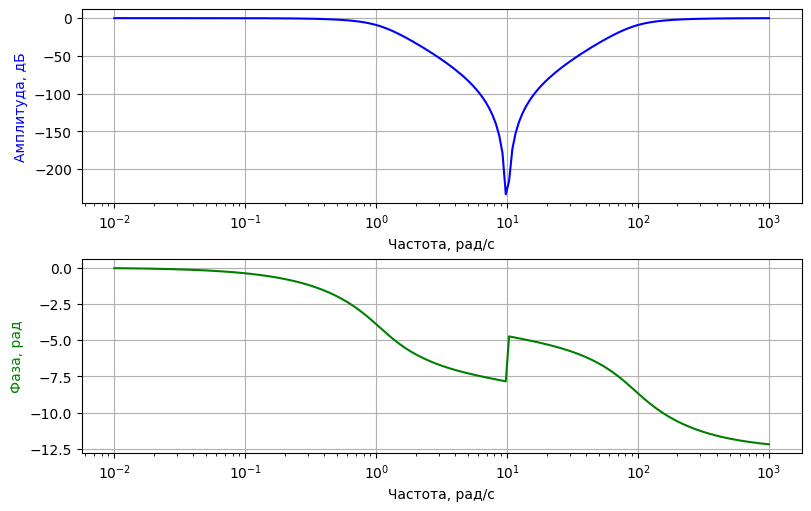

In [26]:
# Преобразование прототипа фильтра нижних частот, представленного в виде значений нулей, полюсов и коэффициента усиления
# в форму коэффициентов прямых и обратных связей
# Возвращаемые значения:
# b - коэффициенты прямых связей
# a - коэффициенты обратных связей
# Параметры:
# z - значения нулей фильтра
# p - значения полюсов фильтра
# k - коэффициент усиления фильтра
b, a = sp.zpk2tf(z=z, p=p, k=k)

# Синтез режекторного фильтра по характеристикам прототипа
# Возвращаемые значения:
# b - коэффициенты прямых связей
# a - коэффициенты обратных связей
# Параметры:
# b - коэффициенты прямых связей
# a - коэффициенты обратных связей
# wo - частота середины полосы подавления
# bw - ширина полосы подавления
b1, a1 = sp.lp2bs(b=b, a=a, wo=10, bw=100)

# Функция freqs позволяет указать в качестве параметра plot функцию для отрисовки графиков,
# принимающую в качестве параметров частоты, для которых был измерен отклик фильтра, и комплексные значения этих откликов.
w2, h2 = sp.freqs(b=b1, a=a1, plot=FRPRDiagLog)

#### Синтез аналогового фильтра нижних частот Бесселя

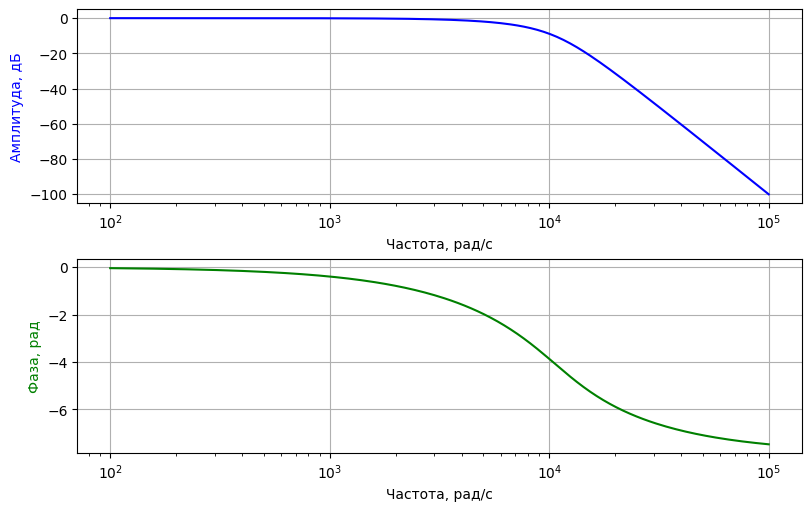

In [27]:
# Синтез фильтра Бесселя
# Возвращаемые значения:
# b - коэффициенты прямых связей
# a - коэффициенты обратных связей
# Параметры:
# N - порядок фильтра
# Wn - критические частоты, для фильтра Бесселя это частоты среза
# btype - тип фильтра:
#    'lowpass' - фильтр нижних частот
#    'highpass' - фильтр верхних частот
#    'bandpass' - полосовой фильтр
#    'bandstop' - режекторный фильтр
# analog - задает синтез аналогового или цифрового фильтра
#    True - аналоговый фильтр
#    False - цифровой фильтр
# output - тип возвращаемых значений:
#    'ba' - коэффициенты прямых и обратных связей
#    'zpk' - значения нулей, полюсов и коэффициент усиления
#    'sos' - массив коэффициентов секций второго порядка
# norm - частотная нормализация:
#   'phase' (по умолчанию) - фильтр нормализуется таким образом, чтобы среднее значение ФЧХ приходилось на частоту 1 рад/с;
#   'delay' - фильтр нормализуется таким образом, чтобы групповая задержка в полосе пропускания равнялась 1
#   'mag' - фильтр нормализуется таким образом, чтобы для частоты 1 рад/c значение АЧХ равнялось -3 дБ.
# fs - частота дискретизации цифрового фильтра
b, a = sp.bessel(N=5, Wn=10000, btype='lowpass', analog=True, output='ba')
w, h = sp.freqs(b=b, a=a, plot=FRPRDiagLog)

#### Расчет аналогового фильтра верхних частот Бесселя

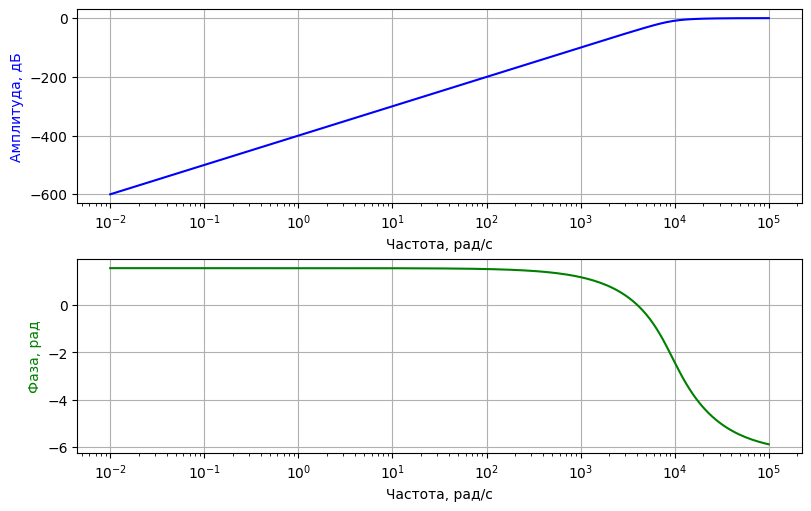

In [28]:
# Расчет фильтра Бесселя
# Возвращаемые значения:
# b - коэффициенты прямых связей
# a - коэффициенты обратных связей
# Параметры:
# N - порядок фильтра
# Wn - критические частоты, для фильтра Бесселя это частоты среза
# btype - тип фильтра:
#    'lowpass' - фильтр нижних частот
#    'highpass' - фильтр верхних частот
#    'bandpass' - полосовой фильтр
#    'bandstop' - режекторный фильтр
# analog - задает синтез аналогового или цифрового фильтра
#    True - аналоговый фильтр
#    False - цифровой фильтр
# output - тип возвращаемых значений:
#    'ba' - коэффициенты прямых и обратных связей
#    'zpk' - значения нулей, полюсов и коэффициент усиления
#    'sos' - массив коэффициентов секций второго порядка
# norm - частотная нормализация:
#   'phase' (по умолчанию) - фильтр нормализуется таким образом, чтобы среднее значение ФЧХ приходилось на частоту 1 рад/с;
#   'delay' - фильтр нормализуется таким образом, чтобы групповая задержка в полосе пропускания равнялась 1
#   'mag' - фильтр нормализуется таким образом, чтобы для частоты 1 рад/c значение АЧХ равнялось -3 дБ.
# fs - частота дискретизации цифрового фильтра
b, a = sp.bessel(N=5, Wn=10000, btype='highpass', analog=True, output='ba')
w, h = sp.freqs(b=b, a=a, plot=FRPRDiagLog)

#### Расчет аналогового полосового фильтра Бесселя

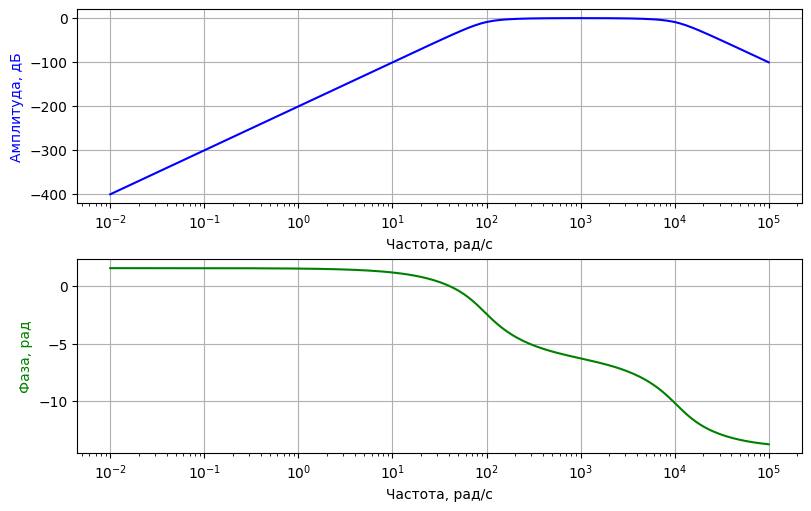

In [29]:
# Расчет фильтра Бесселя
# Возвращаемые значения:
# b - коэффициенты прямых связей
# a - коэффициенты обратных связей
# Параметры:
# N - порядок фильтра
# Wn - критические частоты, для фильтра Бесселя это частоты среза
# btype - тип фильтра:
#    'lowpass' - фильтр нижних частот
#    'highpass' - фильтр верхних частот
#    'bandpass' - полосовой фильтр
#    'bandstop' - режекторный фильтр
# analog - задает синтез аналогового или цифрового фильтра
#    True - аналоговый фильтр
#    False - цифровой фильтр
# output - тип возвращаемых значений:
#    'ba' - коэффициенты прямых и обратных связей
#    'zpk' - значения нулей, полюсов и коэффициент усиления
#    'sos' - массив коэффициентов секций второго порядка
# norm - частотная нормализация:
#   'phase' (по умолчанию) - фильтр нормализуется таким образом, чтобы среднее значение ФЧХ приходилось на частоту 1 рад/с;
#   'delay' - фильтр нормализуется таким образом, чтобы групповая задержка в полосе пропускания равнялась 1
#   'mag' - фильтр нормализуется таким образом, чтобы для частоты 1 рад/c значение АЧХ равнялось -3 дБ.
# fs - частота дискретизации цифрового фильтра
b, a = sp.bessel(N=5, Wn=[100, 10000], btype='bandpass', analog=True, output='ba')
w, h = sp.freqs(b=b, a=a, plot=FRPRDiagLog)

#### Расчет аналогового режекторного фильтра Бесселя

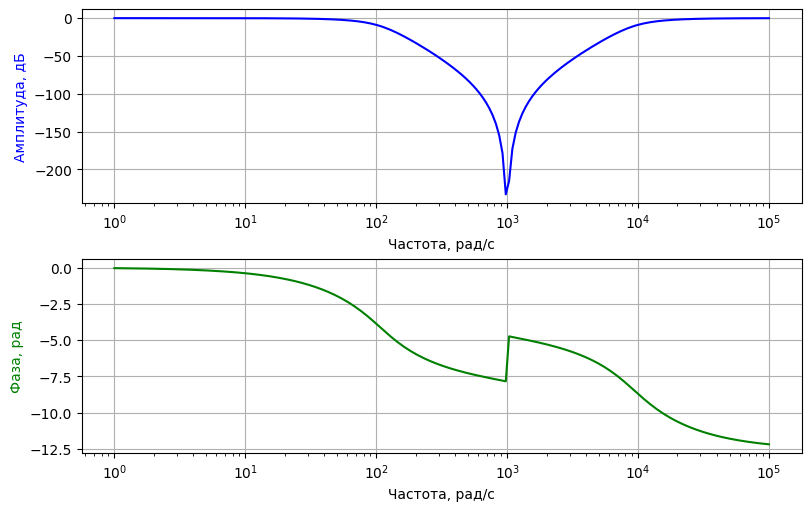

In [30]:
# Расчет фильтра Бесселя
# Возвращаемые значения:
# b - коэффициенты прямых связей
# a - коэффициенты обратных связей
# Параметры:
# N - порядок фильтра
# Wn - критические частоты, для фильтра Бесселя это частоты среза
# btype - тип фильтра:
#    'lowpass' - фильтр нижних частот
#    'highpass' - фильтр верхних частот
#    'bandpass' - полосовой фильтр
#    'bandstop' - режекторный фильтр
# analog - задает синтез аналогового или цифрового фильтра
#    True - аналоговый фильтр
#    False - цифровой фильтр
# output - тип возвращаемых значений:
#    'ba' - коэффициенты прямых и обратных связей
#    'zpk' - значения нулей, полюсов и коэффициент усиления
#    'sos' - массив коэффициентов секций второго порядка
# norm - частотная нормализация:
#   'phase' (по умолчанию) - фильтр нормализуется таким образом, чтобы среднее значение ФЧХ приходилось на частоту 1 рад/с;
#   'delay' - фильтр нормализуется таким образом, чтобы групповая задержка в полосе пропускания равнялась 1
#   'mag' - фильтр нормализуется таким образом, чтобы для частоты 1 рад/c значение АЧХ равнялось -3 дБ.
# fs - частота дискретизации цифрового фильтра
b, a = sp.bessel(N=5, Wn=[100, 10000], btype='bandstop', analog=True, output='ba')
w, h = sp.freqs(b=b, a=a, plot=FRPRDiagLog)